In [1]:
pip install torchcp

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for torchcp from https://files.pythonhosted.org/packages/08/38/2f3468393a336720de2db7a08b1a70ec762e8741d46dad9e24762ff77cce/torchcp-0.1.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 454.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --index-url https://test.pypi.org/simple/ --no-deps torchcp

Looking in indexes: https://test.pypi.org/simple/, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import numpy as np
import os.path as osp
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import recall_score, f1_score
from torchcp.classification.scores import THR
from torchcp.classification.predictors import SplitPredictor

# 使用cnn对cifar10进行训练

In [12]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = ConvNet()
model=model.cuda()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
def train_batch(model, image, target):
    target = F.one_hot(target, num_classes=10)
    target = target.view(-1, 10)
    output =  model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    target = F.one_hot(target, num_classes=10)
    target = target.view(-1, 10)
    output =  model(image)
    loss = criterion(output, target)
    return output, loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, target):
        num_classes = torch.max(target).item() + 1
        target = F.one_hot(target, num_classes=num_classes)
        target = target.view(-1, num_classes)
        log_prob = torch.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob) ** self.gamma
        target_labels = torch.argmax(target, dim=1)
        ce_loss = self.cross_entropy(input, target_labels)
        focal_loss = focal_weight * ce_loss.mean()
        return focal_loss.mean()
loss_function=FocalLoss(gamma=2)
def train_batch(model, image, target, criterion):
    target = target.squeeze().long()
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target, criterion):
    target_labels = target.squeeze().long()
    output = model(image)
    loss = criterion(output, target_labels)
    loss = criterion(output, target)
    return output, loss
training_loss=[] 
training_acc=[] 
testing_loss=[] 
testing_acc=[] 
train_preds=[] 
train_targets=[] 
test_preds=[] 
test_targets=[] 
train_f1_scores=[]
test_f1_scores=[] 
layer_gradients = [[] for _ in range(len(list(model.parameters())))]


for epoch in range(NUM_EPOCHS): 
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target, loss_function)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().tolist())
        train_targets.extend(target.cpu().tolist())

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        for i, (name, param) in enumerate(model.named_parameters()):
            if param.grad is not None:
                layer_gradients[i].append(param.grad.abs().mean().item())
           
    
        optimizer.step()
        optimizer.zero_grad()
    train_recall = recall_score(train_targets, train_preds, average='weighted')
    train_f1 = f1_score(train_targets, train_preds, average='weighted')
    train_f1_scores.append(train_f1)
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Train Recall: {train_recall:.4f} F1 Score: {train_f1:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    train_f1 = f1_score(train_targets, train_preds, average='weighted')

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target,loss_function)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().tolist())
            test_targets.extend(target.cpu().tolist())
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        test_recall = recall_score(test_targets, test_preds, average='weighted')
        test_f1 = f1_score(test_targets, test_preds, average='weighted')
        test_f1_scores.append(test_f1)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Test Recall: {test_recall:.4f} F1 Score: {test_f1:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

        # 创建预测器实例
        predictor = SplitPredictor(score_function=THR(), model=model)

        # 校准数据集的准备（这里使用训练集的一部分进行校准）
        cal_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # 校准预测器
        predictor.calibrate(cal_dataloader, alpha=0.1)

        # 使用测试集进行预测
        predict_sets = []
        for images, _ in test_dataloader:
            images = images.to(device)
            batch_predict_sets = predictor.predict(images)
            predict_sets.extend(batch_predict_sets)
        # 评估覆盖率和平均集合大小
        result_dict = predictor.evaluate(test_dataloader)
        print(result_dict["Coverage_rate"], result_dict["Average_size"])

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/30 Train Loss: 0.0120 Acc: 0.2964
Train Recall: 0.2964 F1 Score: 0.2907
Begin test......
Test Loss: 0.0110 Acc: 0.3599
Test Recall: 0.3599 F1 Score: 0.3227
0.9122 4.9399
Epoch: 2/30 Train Loss: 0.0111 Acc: 0.3618
Train Recall: 0.3291 F1 Score: 0.3232
Begin test......
Test Loss: 0.0102 Acc: 0.4161
Test Recall: 0.3880 F1 Score: 0.3754
0.9166 4.5982
Epoch: 3/30 Train Loss: 0.0109 Acc: 0.3810
Train Recall: 0.3464 F1 Score: 0.3409
Begin test......
Test Loss: 0.0101 Acc: 0.4253
Test Recall: 0.4004 F1 Score: 0.3903
0.9146 4.508
Epoch: 4/30 Train Loss: 0.0109 Acc: 0.3837
Train Recall: 0.3557 F1 Score: 0.3504
Begin test......
Test Loss: 0.0108 Acc: 0.4030
Test Recall: 0.4011 F1 Score: 0.3900
0.91 4.8542
Epoch: 5/30 Train Loss: 0.0108 Acc: 0.3873
Train Recall: 0.3620 F1 Score: 0.3569
Begin test......
Test Loss: 0.0106 Acc: 0.3860
Test Recall: 0.3981 F1 Score: 0.3913
0.9144 4.7166
Epoch: 6/30 Train Loss: 0.0102 A

NameError: name 'osp' is not defined

In [13]:
# 创建预测器实例
predictor = SplitPredictor(score_function=THR(), model=model)

# 校准数据集的准备（这里使用训练集的一部分进行校准）
cal_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 校准预测器
predictor.calibrate(cal_dataloader, alpha=0.1)

# 使用测试集进行预测
predict_sets = []
for images, _ in test_dataloader:
    images = images.to(device)
    batch_predict_sets = predictor.predict(images)
    predict_sets.extend(batch_predict_sets)
# 评估覆盖率和平均集合大小（上面未显示的第30个eppch）
result_dict = predictor.evaluate(test_dataloader)
print(result_dict["Coverage_rate"], result_dict["Average_size"])

0.9137 3.232


# 对各个CPscore和算法初步评估

In [23]:
import torch
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor

weight_for_saps = 1.0
penalty=0.5
score_functions = [THR(), APS(), SAPS(weight=weight_for_saps), RAPS(penalty)]
predictors = [SplitPredictor, ClusterPredictor, ClassWisePredictor]  # 假设您已实现 ClusterPredictor

# 用于存储不同组合的性能结果
performance_results = []

for score_function in score_functions:
    for Predictor in predictors:
        # 创建预测器实例
        predictor = Predictor(score_function=score_function, model=model)

        # 校准数据集的准备
        cal_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # 校准预测器
        predictor.calibrate(cal_dataloader, alpha=0.1)

        # 使用测试集进行预测
        predict_sets = []
        for images, _ in test_dataloader:
            images = images.to(device)
            batch_predict_sets = predictor.predict(images)
            predict_sets.extend(batch_predict_sets)

        # 评估覆盖率和平均集合大小
        result_dict = predictor.evaluate(test_dataloader)
        coverage_rate, average_size = result_dict["Coverage_rate"], result_dict["Average_size"]
        
        # 记录性能结果
        performance_results.append((score_function.__class__.__name__, Predictor.__name__, coverage_rate, average_size))

# 打印性能结果
for result in performance_results:
    print(f"Score Function: {result[0]}, Predictor: {result[1]}, Coverage Rate: {result[2]:.4f}, Average Set Size: {result[3]:.4f}")

Score Function: THR, Predictor: SplitPredictor, Coverage Rate: 0.9137, Average Set Size: 3.2322
Score Function: THR, Predictor: ClusterPredictor, Coverage Rate: 0.9159, Average Set Size: 3.2672
Score Function: THR, Predictor: ClassWisePredictor, Coverage Rate: 0.9159, Average Set Size: 3.2482
Score Function: APS, Predictor: SplitPredictor, Coverage Rate: 0.9087, Average Set Size: 3.4526
Score Function: APS, Predictor: ClusterPredictor, Coverage Rate: 0.9075, Average Set Size: 3.4382
Score Function: APS, Predictor: ClassWisePredictor, Coverage Rate: 0.9092, Average Set Size: 3.4748
Score Function: SAPS, Predictor: SplitPredictor, Coverage Rate: 0.9174, Average Set Size: 3.8331
Score Function: SAPS, Predictor: ClusterPredictor, Coverage Rate: 0.9174, Average Set Size: 3.8580
Score Function: SAPS, Predictor: ClassWisePredictor, Coverage Rate: 0.9176, Average Set Size: 3.8669
Score Function: RAPS, Predictor: SplitPredictor, Coverage Rate: 0.9190, Average Set Size: 3.8944
Score Function: RA

# 对RPS的penalty值进行交叉验证

In [22]:
from torchcp.classification.predictors import ClusterPredictor
from sklearn.model_selection import KFold
penalty_values = [0.1, 0.3, 0.5, 0.7, 0.9]
k_folds = 5
performance_results = []
for penalty in penalty_values:
    # 定义当前`penalty`下的性能结果列表
    current_performance_results = []

    # 定义交叉验证的折迭代器
    kf = KFold(n_splits=k_folds, shuffle=True)

    # 进行交叉验证
    for train_index, val_index in kf.split(train_set):

        # 创建预测器实例，3个算法对于RPS初步看来表现差距不大，选择表现较好的ClusterPredictor
        predictor = ClusterPredictor(score_function=RAPS(penalty=penalty), model=model)
        
        # 校准数据集的准备
        cal_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        # 校准预测器
        predictor.calibrate(cal_dataloader, alpha=0.1)

        # 使用验证集进行预测
        predict_sets = []
        for images, _ in val_subset:
            images = images.to(device)
            batch_predict_sets = predictor.predict(images)
            predict_sets.extend(batch_predict_sets)

        # 评估覆盖率和平均集合大小
        result_dict = predictor.evaluate(test_dataloader)
        coverage_rate, average_size = result_dict["Coverage_rate"], result_dict["Average_size"]

        # 记录性能结果
        current_performance_results.append((coverage_rate, average_size))

    # 计算平均性能结果
    avg_coverage_rate = sum(result[0] for result in current_performance_results) / k_folds
    avg_average_size = sum(result[1] for result in current_performance_results) / k_folds

    # 记录当前`penalty`下的平均性能结果
    performance_results.append((penalty, avg_coverage_rate, avg_average_size))
# 打印性能结果
for result in performance_results:
    print(f"Penalty: {result[0]}, Average Coverage Rate: {result[1]:.4f}, Average Set Size: {result[2]:.4f}")

Penalty: 0.1, Average Coverage Rate: 0.9170, Average Set Size: 3.6392
Penalty: 0.3, Average Coverage Rate: 0.9180, Average Set Size: 3.8038
Penalty: 0.5, Average Coverage Rate: 0.9187, Average Set Size: 3.9092
Penalty: 0.7, Average Coverage Rate: 0.9183, Average Set Size: 3.8686
Penalty: 0.9, Average Coverage Rate: 0.9170, Average Set Size: 3.7989


根据这些结果，选择penalty为0.5作为最佳的选择。这个penalty值在平衡错误预测的惩罚程度方面表现良好，同时提供了较高的覆盖率和适当的集合大小。

# 对SAP的weight值交叉验证

In [26]:
weight_values = [0.1, 0.3, 0.5, 0.7, 0.9]
k_folds = 5
performance_results = []
for weight in weight_values:
    # 定义当前权重下的性能结果列表
    current_performance_results = []

    # 定义交叉验证的折迭代器
    kf = KFold(n_splits=k_folds, shuffle=True)

    # 进行交叉验证
    for train_index, val_index in kf.split(train_set):

        # 创建预测器实例
        predictor = ClassWisePredictor(score_function=SAPS(weight=weight), model=model)

        # 校准数据集的准备
        train_subset = torch.utils.data.Subset(train_set, train_index)
        val_subset = torch.utils.data.Subset(train_set, val_index)
        cal_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # 校准预测器
        predictor.calibrate(cal_dataloader, alpha=0.1)

        # 使用验证集进行预测
        predict_sets = []
        for images, _ in val_subset:
            images = images.to(device)
            batch_predict_sets = predictor.predict(images)
            predict_sets.extend(batch_predict_sets)

        # 评估覆盖率和平均集合大小
        result_dict = predictor.evaluate(test_dataloader)
        coverage_rate, average_size = result_dict["Coverage_rate"], result_dict["Average_size"]

        # 记录性能结果
        current_performance_results.append((coverage_rate, average_size))

    # 计算平均性能结果
    avg_coverage_rate = sum(result[0] for result in current_performance_results) / k_folds
    avg_average_size = sum(result[1] for result in current_performance_results) / k_folds

    # 记录当前权重下的平均性能结果
    performance_results.append((weight, avg_coverage_rate, avg_average_size))
# 打印性能结果
for result in performance_results:
    print(f"Weight: {result[0]}, Average Coverage Rate: {result[1]:.4f}, Average Set Size: {result[2]:.4f}")

Weight: 0.1, Average Coverage Rate: 0.9041, Average Set Size: 3.6989
Weight: 0.3, Average Coverage Rate: 0.9167, Average Set Size: 3.6156
Weight: 0.5, Average Coverage Rate: 0.9173, Average Set Size: 3.7201
Weight: 0.7, Average Coverage Rate: 0.9174, Average Set Size: 3.8084
Weight: 0.9, Average Coverage Rate: 0.9178, Average Set Size: 3.8576


根据结果选择weight为0.3能对准确率和集合大小做一个较好的平衡

# 对选择的CPscore和算法使用交叉验证得到结果

In [28]:
import torch
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from sklearn.model_selection import KFold

# 定义K折交叉验证的折数
k_folds = 5

#选择相对最优的weight和penalty
weight_for_saps = 0.3
penalty=0.5

# 定义待评估的CP分数和算法组合
score_functions = [THR(), APS(), SAPS(weight=weight_for_saps), RAPS(penalty)]
predictors = [SplitPredictor, ClusterPredictor, ClassWisePredictor]

# 用于存储不同组合的性能结果
performance_results = []

# 创建交叉验证的折迭代器
kf = KFold(n_splits=k_folds, shuffle=True)

# 进行交叉验证
for score_function in score_functions:
    for Predictor in predictors:
        # 定义当前组合的性能结果列表
        current_performance_results = []

        # 进行交叉验证的循环
        for train_index, val_index in kf.split(train_set):
          

            # 创建预测器实例
            predictor = Predictor(score_function=score_function, model=model)

            # 校准数据集的准备
            train_subset = torch.utils.data.Subset(train_set, train_index)
            val_subset = torch.utils.data.Subset(train_set, val_index)
            cal_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

            # 校准预测器
            predictor.calibrate(cal_dataloader, alpha=0.1)

            # 使用验证集进行预测
            predict_sets = []
            for images, _ in val_subset:
                images = images.to(device)
                batch_predict_sets = predictor.predict(images)
                predict_sets.extend(batch_predict_sets)

            # 评估覆盖率和平均集合大小
            result_dict = predictor.evaluate(test_dataloader)
            coverage_rate, average_size = result_dict["Coverage_rate"], result_dict["Average_size"]

            # 记录性能结果
            current_performance_results.append((coverage_rate, average_size))

        # 计算平均性能结果
        avg_coverage_rate = sum(result[0] for result in current_performance_results) / k_folds
        avg_average_size = sum(result[1] for result in current_performance_results) / k_folds

        # 记录当前组合的平均性能结果
        performance_results.append((score_function.__class__.__name__, Predictor.__name__, avg_coverage_rate, avg_average_size))

# 打印性能结果
for result in performance_results:
    print(f"Score Function: {result[0]}, Predictor: {result[1]}, Average Coverage Rate: {result[2]:.4f}, Average Set Size: {result[3]:.4f}")

Score Function: THR, Predictor: SplitPredictor, Average Coverage Rate: 0.9149, Average Set Size: 3.2488
Score Function: THR, Predictor: ClusterPredictor, Average Coverage Rate: 0.9142, Average Set Size: 3.2410
Score Function: THR, Predictor: ClassWisePredictor, Average Coverage Rate: 0.9161, Average Set Size: 3.2592
Score Function: APS, Predictor: SplitPredictor, Average Coverage Rate: 0.9081, Average Set Size: 3.4557
Score Function: APS, Predictor: ClusterPredictor, Average Coverage Rate: 0.9080, Average Set Size: 3.4582
Score Function: APS, Predictor: ClassWisePredictor, Average Coverage Rate: 0.9091, Average Set Size: 3.5043
Score Function: SAPS, Predictor: SplitPredictor, Average Coverage Rate: 0.9154, Average Set Size: 3.5945
Score Function: SAPS, Predictor: ClusterPredictor, Average Coverage Rate: 0.9161, Average Set Size: 3.5905
Score Function: SAPS, Predictor: ClassWisePredictor, Average Coverage Rate: 0.9160, Average Set Size: 3.6079
Score Function: RAPS, Predictor: SplitPredi

# 可视化结果

#  cifar10

In [31]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/2d/46/cf3fce41ffc543b6e94dadbe6b647559d591df446ec716e72c3b4ce71b34/seaborn-0.13.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 1.8 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


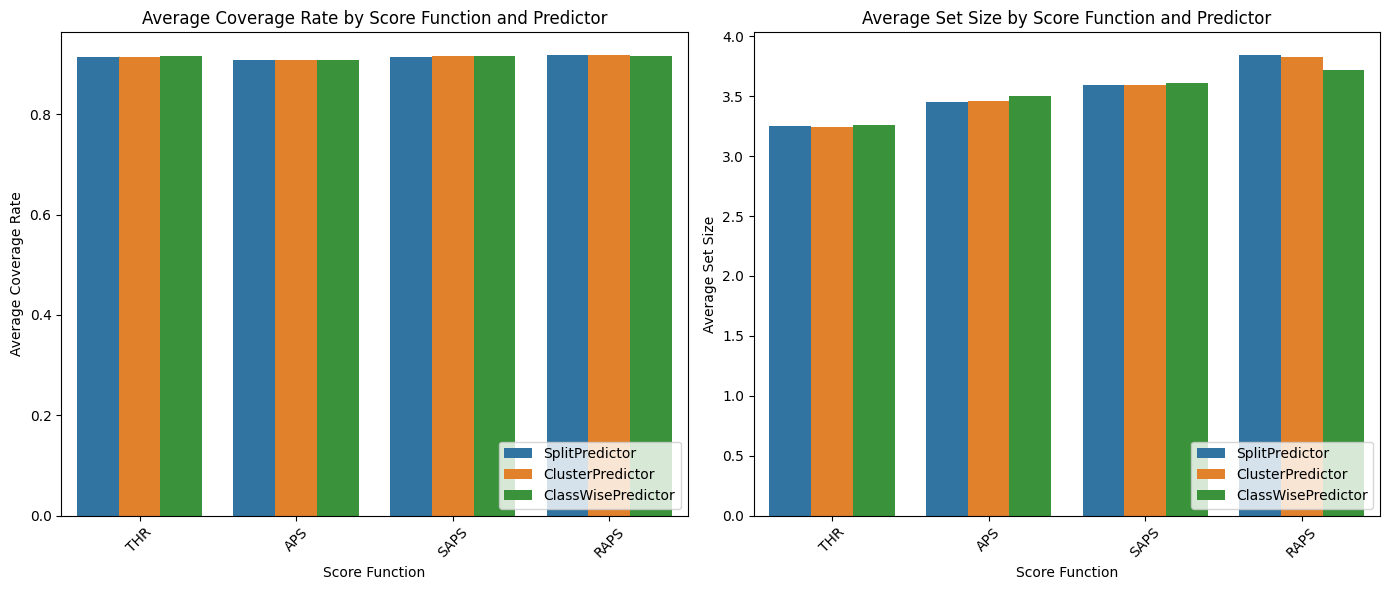

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
cifar10_data = {
    'Score Function': ['THR', 'THR', 'THR', 'APS', 'APS', 'APS', 'SAPS', 'SAPS', 'SAPS', 'RAPS', 'RAPS', 'RAPS'],
    'Predictor': ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor'],
    'Average Coverage Rate': [0.9149, 0.9142, 0.9161, 0.9081, 0.9080, 0.9091, 
                              0.9154, 0.9161, 0.9160, 0.9178, 0.9176, 0.9171],
    'Average Set Size': [3.2488, 3.2410, 3.2592, 3.4557, 3.4582, 3.5043, 
                         3.5945, 3.5905, 3.6079, 3.8419, 3.8304, 3.7225]
}


df = pd.DataFrame(cifar10_data )

# Plotting
plt.figure(figsize=(14, 6))

# Plot for Average Coverage Rate
plt.subplot(1, 2, 1)
sns.barplot(x='Score Function', y='Average Coverage Rate', hue='Predictor', data=df)
plt.title('Average Coverage Rate by Score Function and Predictor')
plt.ylabel('Average Coverage Rate')
plt.xlabel('Score Function')
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# Plot for Average Set Size
plt.subplot(1, 2, 2)
sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df)
plt.title('Average Set Size by Score Function and Predictor')
plt.ylabel('Average Set Size')
plt.xlabel('Score Function')
plt.xticks(rotation=45)

# Move the legend to the bottom right corner
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#  cifar100

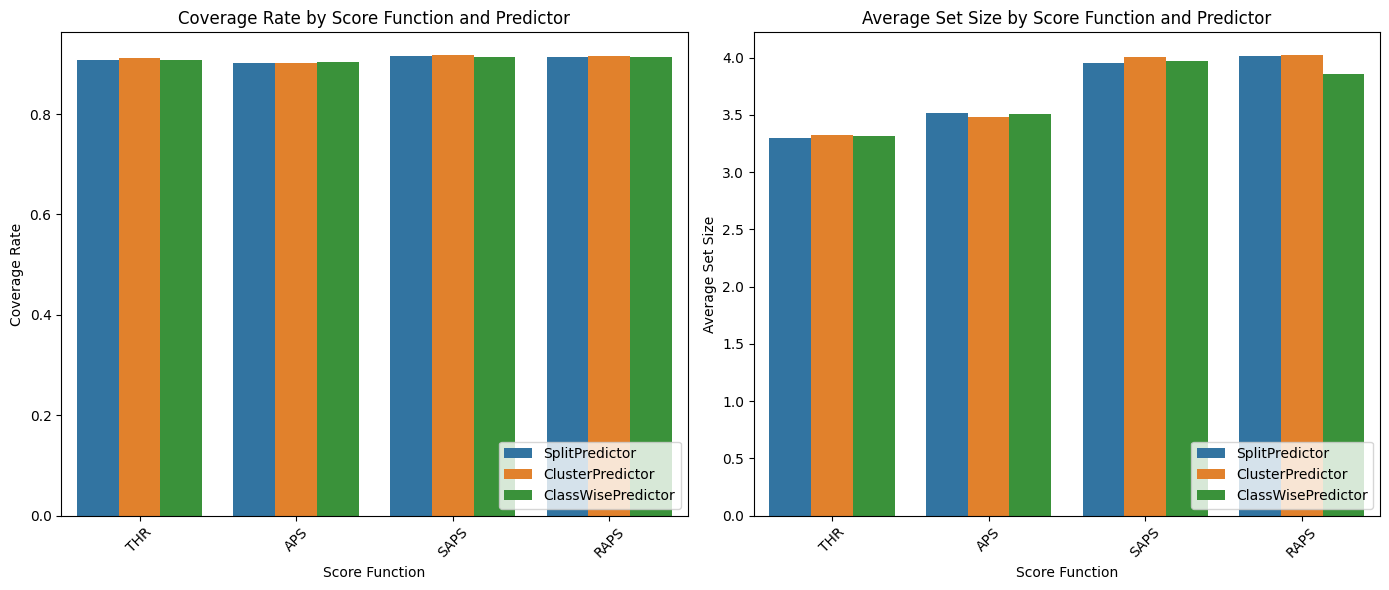

In [41]:

cifar100_data= {
    'Score Function': ['THR', 'THR', 'THR', 'APS', 'APS', 'APS', 'SAPS', 'SAPS', 'SAPS', 'RAPS', 'RAPS', 'RAPS'],
    'Predictor': ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor'],
    'Coverage Rate': [0.9086, 0.9110, 0.9069, 0.9022, 0.9017, 0.9038, 
                      0.9158, 0.9170, 0.9137, 0.9144, 0.9147, 0.9128],
    'Average Set Size': [3.2963, 3.3260, 3.3107, 3.5150, 3.4846, 3.5068, 
                         3.9558, 4.0011, 3.9660, 4.0156, 4.0194, 3.8588]
}

df = pd.DataFrame(cifar100_data)

# 绘制图表
plt.figure(figsize=(14, 6))

# 覆盖率的图表
plt.subplot(1, 2, 1)
sns.barplot(x='Score Function', y='Coverage Rate', hue='Predictor', data=df)
plt.title('Coverage Rate by Score Function and Predictor')
plt.ylabel('Coverage Rate')
plt.xlabel('Score Function')
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# 平均集合大小的图表
plt.subplot(1, 2, 2)
sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df)
plt.title('Average Set Size by Score Function and Predictor')
plt.ylabel('Average Set Size')
plt.xlabel('Score Function')
plt.xticks(rotation=45)

# 将图例移动到右下角
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


#  MINIST

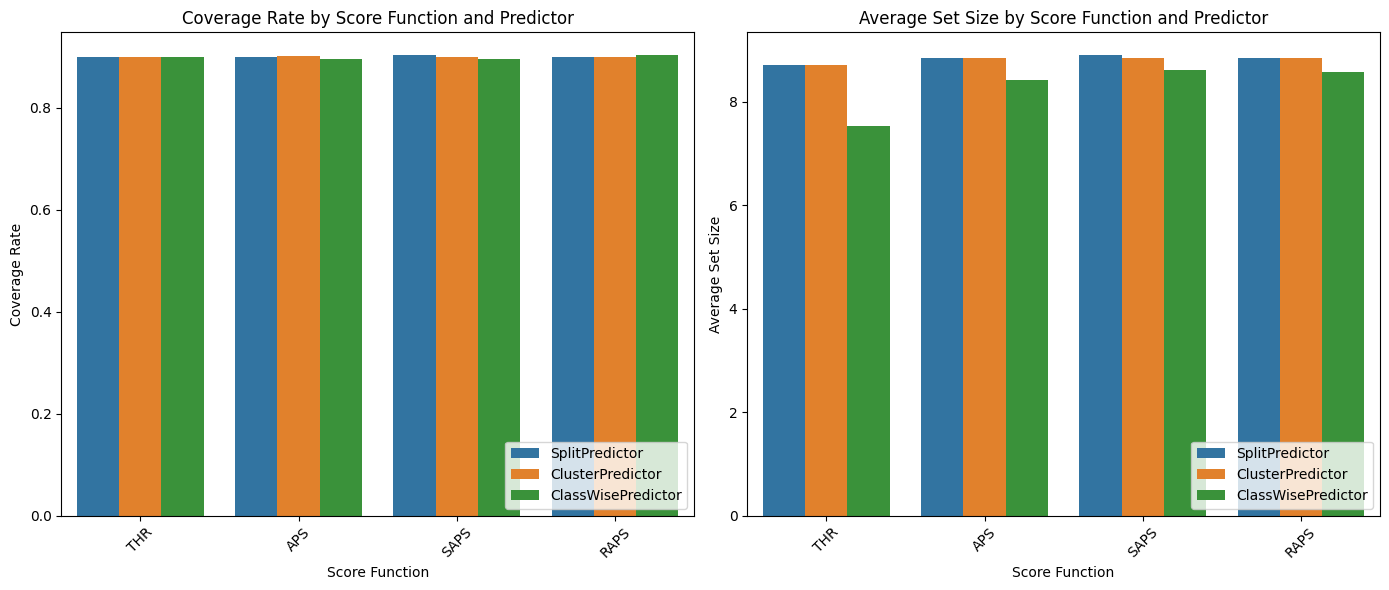

In [52]:
# 数据准备
MINIST_data  = {
    'Score Function': ['THR', 'THR', 'THR', 'APS', 'APS', 'APS', 'SAPS', 'SAPS', 'SAPS', 'RAPS', 'RAPS', 'RAPS'],
    'Predictor': ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor'],
    'Coverage Rate': [0.9000, 0.9009, 0.9004, 0.9002, 0.9011, 0.8970, 
                      0.9032, 0.8995, 0.8966, 0.8998, 0.9001, 0.9029],
    'Average Set Size': [8.7136, 8.7182, 7.5346, 8.8408, 8.8405, 8.4201, 
                         8.8980, 8.8528, 8.6131, 8.8524, 8.8408, 8.5760]
}

df = pd.DataFrame(MINIST_data )

# 绘制图表
plt.figure(figsize=(14, 6))

# 覆盖率的图表
plt.subplot(1, 2, 1)
sns.barplot(x='Score Function', y='Coverage Rate', hue='Predictor', data=df)
plt.title('Coverage Rate by Score Function and Predictor')
plt.ylabel('Coverage Rate')
plt.xlabel('Score Function')
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# 平均集合大小的图表
plt.subplot(1, 2, 2)
sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df)
plt.title('Average Set Size by Score Function and Predictor')
plt.ylabel('Average Set Size')
plt.xlabel('Score Function')
plt.xticks(rotation=45)

# 将图例移动到右下角
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


#  银行客户流失数据

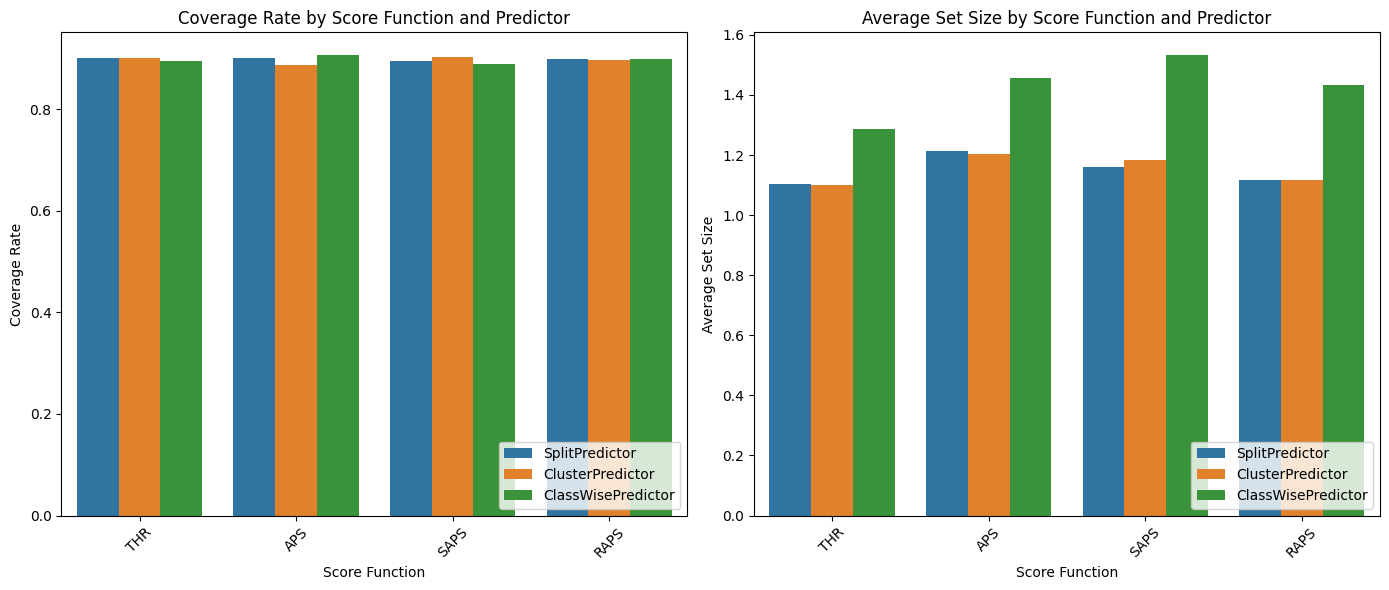

In [44]:

# 数据准备
BankChurn_data = {
    'Score Function': ['THR', 'THR', 'THR', 'APS', 'APS', 'APS', 'SAPS', 'SAPS', 'SAPS', 'RAPS', 'RAPS', 'RAPS'],
    'Predictor': ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor', 
                  'SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor'],
    'Coverage Rate': [0.9003, 0.8998, 0.8951, 0.9008, 0.8871, 0.9059, 
                      0.8946, 0.9026, 0.8890, 0.8989, 0.8960, 0.8993],
    'Average Set Size': [1.1021, 1.0988, 1.2860, 1.2140, 1.2041, 1.4567, 
                         1.1613, 1.1839, 1.5320, 1.1176, 1.1162, 1.4323]
}

df = pd.DataFrame(BankChurn_data)

# 绘制图表
plt.figure(figsize=(14, 6))

# 覆盖率的图表
plt.subplot(1, 2, 1)
sns.barplot(x='Score Function', y='Coverage Rate', hue='Predictor', data=df)
plt.title('Coverage Rate by Score Function and Predictor')
plt.ylabel('Coverage Rate')
plt.xlabel('Score Function')
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# 平均集合大小的图表
plt.subplot(1, 2, 2)
sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df)
plt.title('Average Set Size by Score Function and Predictor')
plt.ylabel('Average Set Size')
plt.xlabel('Score Function')
plt.xticks(rotation=45)

# 将图例移动到右下角
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


#  对四个模型的覆盖率对比

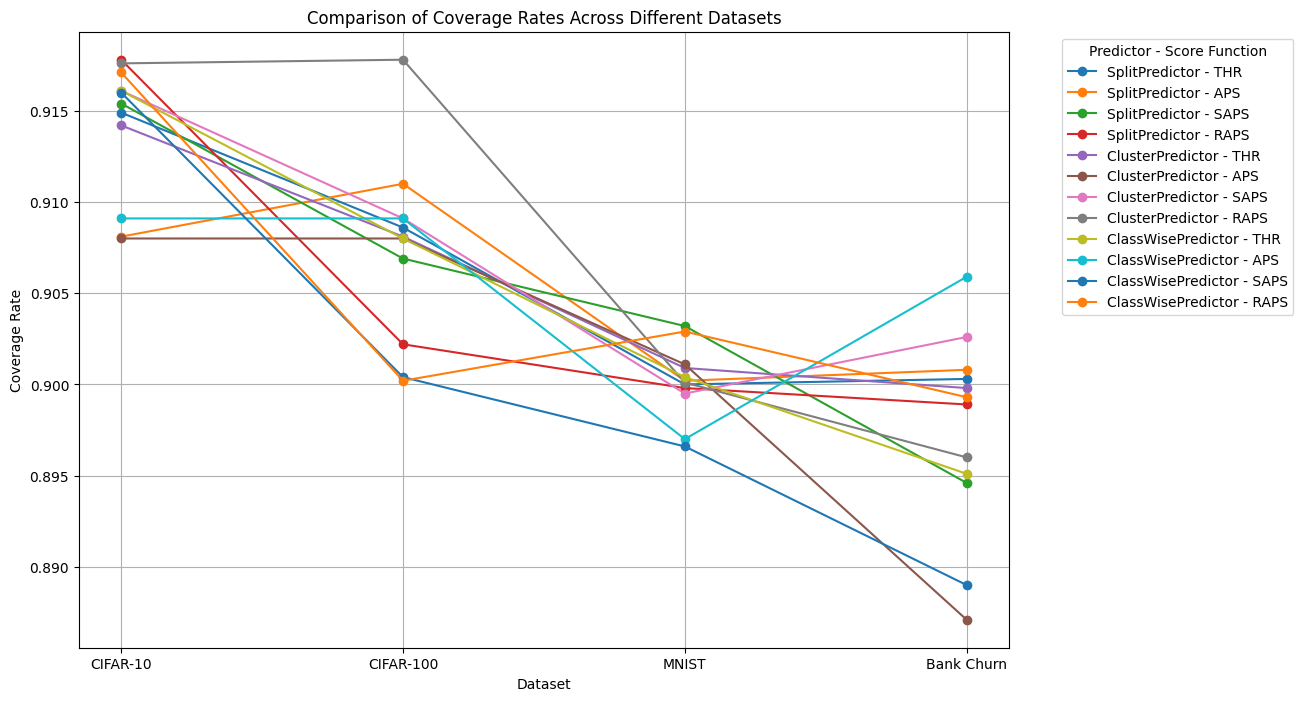

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data for the four datasets as DataFrames
cifar10_data =pd.DataFrame(cifar10_data)

cifar100_data =pd.DataFrame(cifar100_data)

MINIST_data = pd.DataFrame(MINIST_data)

BankChurn_data =pd.DataFrame(BankChurn_data)

# Combine the data from all datasets
combined_data = pd.concat([cifar10_data, cifar100_data, MINIST_data, BankChurn_data])

# Plotting function for the combined data
def plot_combined_data(data):
    fig, ax = plt.subplots(figsize=(12, 8))
    predictors = data['Predictor'].unique()
    score_functions = data['Score Function'].unique()
    datasets = data['Dataset'].unique()

    for predictor in predictors:
        for score_function in score_functions:
            subset = data[(data['Predictor'] == predictor) & (data['Score Function'] == score_function)]
            ax.plot(subset['Dataset'], subset['Coverage Rate'], marker='o', label=f'{predictor} - {score_function}')

    ax.set_title('Comparison of Coverage Rates Across Different Datasets')
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Coverage Rate')
    ax.legend(title='Predictor - Score Function', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(datasets)
    plt.grid(True)
    plt.show()

# Running the plotting function
plot_combined_data(combined_data)
